# 02 — Clustering the Combined Universe

Runs OPTICS on the full cross-sector universe. Pairs are discovered
by the clustering algorithm without sector boundaries — if two stocks from
different sectors cluster together, that's a real finding.

After clustering, we tag each pair with sector info to analyze
whether intra-sector pairs dominate or if cross-sector relationships emerge.

In [1]:
import sys, os

project_root = os.path.abspath(os.path.join('..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import DEFAULT_CONFIG
from signals.detection import (
    build_cluster_history, detect_formation_events, compute_co_cluster_freq,
)
from screener.universe import load_cached_universe
from screener.features_adapter import compute_features_for_universe

%matplotlib inline
pd.set_option('display.max_columns', 50)

## 1. Load Combined Universe

In [2]:
tickers, prices, sector_map = load_cached_universe('combined')

if tickers is None:
    raise RuntimeError("Combined universe not cached. Run notebook 01 first.")

n_stocks = len([t for t in tickers if t != '^GSPC'])
print(f"Loaded: {n_stocks} stocks, {len(prices)} timestamps")
print(f"Sector map: {len(sector_map)} tickers")

sector_counts = pd.Series(sector_map).value_counts()
for sector, count in sector_counts.items():
    print(f"  {sector}: {count}")

Loaded: 142 stocks, 1744 timestamps
Sector map: 142 tickers
  Technology: 59
  Energy: 27
  Healthcare: 23
  Industrials: 18
  Financial Services: 15


## 2. Compute Features

In [3]:
print("Computing features...")
ts_df = compute_features_for_universe(prices, cfg=DEFAULT_CONFIG.features)

n_tickers = ts_df.index.get_level_values('Ticker').nunique()
n_timestamps = ts_df.index.get_level_values('Datetime').nunique()
print(f"Features: {ts_df.shape[0]} rows, {ts_df.shape[1]} columns")
print(f"{n_tickers} tickers x {n_timestamps} timestamps")

Computing features...


Features: 201498 rows, 13 columns
142 tickers x 1419 timestamps


## 3. Run OPTICS Clustering

In [4]:
print("Building cluster history (this will take a while with the full universe)...")
cluster_history = build_cluster_history(
    ts_df, cfg=DEFAULT_CONFIG.clustering, feat_cfg=DEFAULT_CONFIG.features
)

n_valid = cluster_history['Datetime'].nunique()
noise_rate = (cluster_history['Cluster_ID'] == -1).mean()
n_clusters_per_ts = cluster_history[
    cluster_history['Cluster_ID'] != -1
].groupby('Datetime')['Cluster_ID'].nunique()

print(f"Valid snapshots: {n_valid}/{n_timestamps}")
print(f"Noise rate: {noise_rate:.1%}")
print(f"Avg clusters per snapshot: {n_clusters_per_ts.mean():.1f}")

Building cluster history (this will take a while with the full universe)...


Valid snapshots: 1002/1419
Noise rate: 67.5%
Avg clusters per snapshot: 10.3


## 4. Co-Cluster Frequencies & Formation Events

In [5]:
print("Computing co-cluster frequencies...")
pair_freq, total_windows = compute_co_cluster_freq(cluster_history)
print(f"Total unique co-clustering pairs: {len(pair_freq)}")

print("\nDetecting formation events...")
df_formations, df_durations = detect_formation_events(
    cluster_history, pair_freq, cfg=DEFAULT_CONFIG.formation
)
print(f"Formations: {len(df_formations)}, Duration records: {len(df_durations)}")

Computing co-cluster frequencies...


Total unique co-clustering pairs: 7836

Detecting formation events...


Formations: 49495, Duration records: 49495


## 5. Top Pairs — Tagged by Sector

In [6]:
top_pairs = sorted(pair_freq.items(), key=lambda x: x[1], reverse=True)[:20]

print(f"Top 20 pairs (by raw co-cluster count out of {total_windows} windows):")
print(f"{'Pair':<25s} {'Count':>6s} {'Freq':>7s}  {'Sector A':<22s} {'Sector B':<22s} {'Type'}")
print('-' * 100)
for (a, b), count in top_pairs:
    sa = sector_map.get(a, '?')
    sb = sector_map.get(b, '?')
    ptype = 'INTRA' if sa == sb else 'CROSS'
    print(f"{a}-{b:<20s} {count:>6d} {count/total_windows:>6.1%}  {sa:<22s} {sb:<22s} {ptype}")

Top 20 pairs (by raw co-cluster count out of 1002 windows):
Pair                       Count    Freq  Sector A               Sector B               Type
----------------------------------------------------------------------------------------------------
PBR-PBR-A                   572  57.1%  Energy                 Energy                 INTRA
DAL-UAL                     341  34.0%  Industrials            Industrials            INTRA
AAL-DAL                     329  32.8%  Industrials            Industrials            INTRA
CVX-XOM                     316  31.5%  Energy                 Energy                 INTRA
AAL-UAL                     307  30.6%  Industrials            Industrials            INTRA
DVN-OXY                     292  29.1%  Energy                 Energy                 INTRA
KMI-WMB                     290  28.9%  Energy                 Energy                 INTRA
DVN-PR                      248  24.8%  Energy                 Energy                 INTRA
COP-DVN   

## 6. Intra vs Cross Sector Distribution

All co-clustering pairs: 7836
  Intra-sector: 2225 (28.4%)
  Cross-sector: 5611 (71.6%)


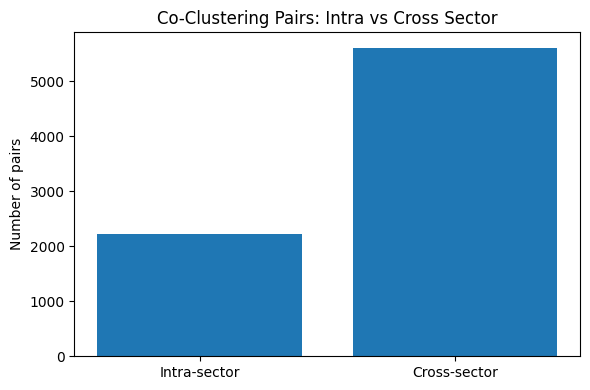

In [7]:
intra_count = 0
cross_count = 0
for (a, b), count in pair_freq.items():
    sa = sector_map.get(a, '?')
    sb = sector_map.get(b, '?')
    if sa == sb and sa != '?':
        intra_count += 1
    else:
        cross_count += 1

total = intra_count + cross_count
print(f"All co-clustering pairs: {total}")
print(f"  Intra-sector: {intra_count} ({intra_count/total:.1%})")
print(f"  Cross-sector: {cross_count} ({cross_count/total:.1%})")

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Intra-sector', 'Cross-sector'], [intra_count, cross_count])
ax.set_title('Co-Clustering Pairs: Intra vs Cross Sector')
ax.set_ylabel('Number of pairs')
plt.tight_layout()
plt.show()

## 7. Save Artifacts

In [8]:
data_dir = os.path.join('..', 'data', 'combined')
os.makedirs(data_dir, exist_ok=True)

artifacts = {
    'ts_df': ts_df,
    'cluster_history': cluster_history,
    'pair_co_cluster_freq': pair_freq,
    'total_windows': total_windows,
    'df_formations': df_formations,
    'df_durations': df_durations,
}

for name, obj in artifacts.items():
    with open(os.path.join(data_dir, f'{name}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

print(f"Saved {len(artifacts)} artifacts to {data_dir}")

Saved 6 artifacts to ../data/combined
